# IMDB 사용자 리뷰 데이터 기반 넷플릭스 추천 시스템 설계

201904207 배성민

202104343 정하은

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import os

df1 = pd.read_csv("/content/drive/MyDrive/수업관련/3-2/파이썬 머신러닝/기말프로젝트/netflix_titles.csv")
df2 = pd.read_csv("/content/drive/MyDrive/수업관련/3-2/파이썬 머신러닝/기말프로젝트/Netflix_score.csv")

# 데이터 전처리

# 결측치 확인



In [27]:
df1.isna().sum(), df2.isna().sum()

(show_id            0
 type               0
 title              0
 director        1969
 cast             570
 country          476
 date_added        11
 release_year       0
 rating            10
 duration           0
 listed_in          0
 description        0
 dtype: int64,
 index                   0
 id                      0
 title                   0
 type                    0
 description             5
 release_year            0
 age_certification    2285
 runtime                 0
 imdb_id                 0
 imdb_score              0
 imdb_votes             16
 dtype: int64)

# 추천 시스템 해볼만한 것

1. date_added 컬럼을 정렬해서 최신 업데이트 콘텐츠 노출

2. cast 컬럼을 이용해서 동일 배우의 출연작품 추천

3. 콘텐츠 설명란을 토대로 다른 콘텐츠 추천

4. imdb평가 데이터의 평가 점수를 토대로 해당 콘텐츠의 설명란과 type을 가지고 콘텐츠를 추천


*   4번에 중점을 둠


# 데이터 병합

In [52]:
# title 열을 기준으로 데이터프레임 결합 (공통 열이 있는 경우 inner join 사용)
merged_df = pd.merge(df1, df2, on='title', how='inner')

# 결측값을 처리할 수 있는 예시 (필요에 따라 다르게 적용)
merged_df.fillna("N/A", inplace=True)  # 결측값을 'N/A'로 채우기

# 또는 특정 열에 대해 결측값 제거
# merged_df = merged_df.dropna(subset=['특정 열'])

# 중복된 열이 있다면, 열 이름 변경 또는 중복 열 제거
# 예: 'type_x', 'type_y'와 같이 자동 생성된 열 이름을 단순화
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]  # 중복 열 제거

# 결과 확인
print(merged_df.head())

    show_id   type_x                       title          director  \
0  80117401    Movie  Jandino: Whatever it Takes               N/A   
1  80125979    Movie                #realityhigh  Fernando Lebrija   
2  80163890  TV Show                     Apaches               N/A   
3  80117902  TV Show                Fire Chasers               N/A   
4  80057969    Movie                        Love        Gaspar Noé   

                                                cast          country  \
0                                   Jandino Asporaat   United Kingdom   
1  Nesta Cooper, Kate Walsh, John Michael Higgins...    United States   
2  Alberto Ammann, Eloy Azorín, Verónica Echegui,...            Spain   
3                                                N/A    United States   
4  Karl Glusman, Klara Kristin, Aomi Muyock, Ugo ...  France, Belgium   

          date_added  release_year_x rating  duration  ... index        id  \
0  September 9, 2016            2016  TV-MA    94 min  ...  17

<ipython-input-52-a25b9f6cf0b6>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("N/A", inplace=True)  # 결측값을 'N/A'로 채우기


# 컬럼 정리

In [53]:
# 필요없는 컬럼 제거
drop_col = ["show_id", "type_x", "country", "date_added", "release_year_x", "release_year_y", "rating", "duration", "index", "age_certification", "runtime", "imdb_id"]

merged_df.drop(columns=drop_col, inplace=True)
merged_df.rename(columns={"type_y":"type", "description_x":"movie_description", "description_y":"review_description"}, inplace=True)

merged_df.head(5)

,title,director,cast,listed_in,movie_description,id,type,review_description,imdb_score,imdb_votes
0,Jandino: Whatever it Takes,N/A,Jandino Asporaat,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,tm244041,MOVIE,Jandino Asporaat riffs on the challenges of ra...,4.5,30.0
1,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",Comedies,When nerdy high schooler Dani finally attracts...,tm320206,MOVIE,When nerdy high schooler Dani finally attracts...,5.2,6283.0
2,Apaches,N/A,"Alberto Ammann, Eloy Azorín, Verónica Echegui,...","Crime TV Shows, International TV Shows, Spanis...",A young journalist is forced into a life of cr...,ts36650,SHOW,A young journalist is forced into a life of cr...,7.0,293.0
3,Fire Chasers,N/A,N/A,"Docuseries, Science & Nature TV","As California's 2016 fire season rages, brave ...",ts75491,SHOW,"As California's 2016 fire season rages, brave ...",6.6,368.0
4,Love,Gaspar Noé,"Karl Glusman, Klara Kristin, Aomi Muyock, Ugo ...","Cult Movies, Dramas, Independent Movies",A man in an unsatisfying marriage recalls the ...,ts38511,SHOW,Rebellious Mickey and good-natured Gus navigat...,7.7,41362.0


# 생각

사용자의 id를 입력 받고, 평가한 영화들의 점수를 토대로 영화추천을 생각해보자.


만약에 A 영화의 긍정적인 평가일 경우 기존의 description을 토대로 추천한 거랑 차이가 있나?


만약에 A 영화의 부정적인 평가일 경우에는 무엇을 기준으로 추천을 해줘야 할 지?

In [30]:
merged_df[merged_df['id'] == "ts38511"]

# 영화제목도 다 똑같고, 리뷰점수도 똑같음.

,title,director,cast,listed_in,movie_description,id,type,review_description,imdb_score,imdb_votes
4,Love,Gaspar Noé,"Karl Glusman, Klara Kristin, Aomi Muyock, Ugo ...","Cult Movies, Dramas, Independent Movies",A man in an unsatisfying marriage recalls the ...,ts38511,SHOW,Rebellious Mickey and good-natured Gus navigat...,7.7,41362.0
424,Love,"Kabir Bhatia, Titien Wattimena","Acha Septriasa, Darius Sinathrya, Fauzi Baadil...","Dramas, International Movies, Romantic Movies","In Jakarta, five couples of varying ages and b...",ts38511,SHOW,Rebellious Mickey and good-natured Gus navigat...,7.7,41362.0
2133,Love,N/A,"Gillian Jacobs, Paul Rust, Claudia O'Doherty","Romantic TV Shows, TV Comedies, TV Dramas",Rebellious Mickey and good-natured Gus navigat...,ts38511,SHOW,Rebellious Mickey and good-natured Gus navigat...,7.7,41362.0


# 생각

위 결과를 보면 부정적인 평가를 남긴 경우 동일한 사용자의 다른 영화의 평점을 토대로 추천해주기에는 무리가 있어 보임.


데이터도 너무 적고, 평가 설명도 똑같고, 평점도 똑같아서.


그럼 부정적인 평가인 경우 해당 영화와 코사인 유사도가 낮은 걸로 해줘야 하나??


어쨋든 다수의 리뷰를 남긴 것들의 장르를 보면 비슷한 류의 프로그램을 보는 것 같음. 그러면 같은 장르의 코사인 유사도가 낮은 거? 아니면 높은 거?

# W2V 모델과 BERT 모델 비교 분석

# 1. W2V 모델

In [31]:
import gensim
from gensim.models import Word2Vec
import re
import torch

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    if isinstance(text, str):  # 문자열인 경우만 처리
        text = text.lower()  # 소문자로 변환
        text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
        return text
    else:
        return ''  # NaN 또는 숫자형 데이터일 경우 빈 문자열 반환

In [32]:
# 원본 텍스트 컬럼 저장
original_movie_description = merged_df['movie_description'].copy()
original_review_description = merged_df['review_description'].copy()
original_listed_in = merged_df['listed_in'].copy()
original_title = merged_df['title'].copy()

merged_df['original_movie_description'] = original_movie_description
merged_df['original_review_description'] = original_review_description
merged_df['original_listed_in'] = original_listed_in
merged_df['title'] = original_title

merged_df['combined'] = merged_df['movie_description'] + ' ' + merged_df['listed_in'] + ' ' + merged_df['title']
merged_df['combined'] = merged_df['combined'].apply(preprocess_text)
merged_df['review_description'] = merged_df['review_description'].apply(preprocess_text)

# 2. Word2Vec 학습 데이터 생성
# 각 문장을 단어 리스트로 나누기
sentences = [row.split() for row in merged_df['combined']]

# 3. Word2Vec 모델 학습
model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# 학습된 단어 벡터 확인 (예: 'action'이라는 단어의 벡터)
print(model.wv['action'])  # action 단어의 벡터

[-1.87965780e-01  5.18204510e-01 -4.51310694e-01  5.72288632e-01
 -1.89126447e-01 -8.93099248e-01  4.72084522e-01  1.41428888e+00
 -1.12584710e+00 -4.31373775e-01  1.87346458e-01 -1.19002295e+00
  4.82464999e-01  2.28226602e-01  5.85429728e-01  1.04841352e-01
  1.16411757e+00 -7.76232839e-01 -3.90467167e-01 -2.04858184e+00
  1.84679717e-01  1.47311062e-01  1.38663208e+00 -1.01901531e+00
  1.78957894e-01  1.57947600e-01 -5.08851886e-01 -7.84316510e-02
 -6.83602035e-01  4.79065806e-01  1.37201107e+00 -1.76211759e-01
  6.14201605e-01 -1.39707553e+00 -4.65479523e-01  7.94386446e-01
  5.48416674e-02 -2.07395375e-01 -6.67217791e-01 -9.43653107e-01
  1.56027868e-01 -6.67012036e-01 -9.49758440e-02  2.56723046e-01
  1.01650047e+00 -3.19127440e-01 -1.04704905e+00  1.54392138e-01
  1.69571415e-01  8.12929332e-01 -1.08110733e-01 -2.15282425e-01
 -3.18694413e-01  2.02187926e-01 -5.67739189e-01  6.40589893e-02
 -5.86448461e-02  1.34116471e-01 -5.26150346e-01  6.77738130e-01
  2.21486464e-01 -3.23250

In [33]:
def get_sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # 단어가 없는 경우 0 벡터 반환
    return np.mean(word_vectors, axis=0)

merged_df['vector'] = merged_df['combined'].apply(lambda x: get_sentence_vector(x, model))
merged_df['re_vector'] = merged_df['review_description'].apply(lambda x: get_sentence_vector(x, model))

from sklearn.metrics.pairwise import cosine_similarity
vectors = np.vstack(merged_df['vector'].values)
review_vectors = np.vstack(merged_df['re_vector'].values)
cosine_sim = cosine_similarity(vectors, vectors)
cosine_sim_re = cosine_similarity(review_vectors, review_vectors)

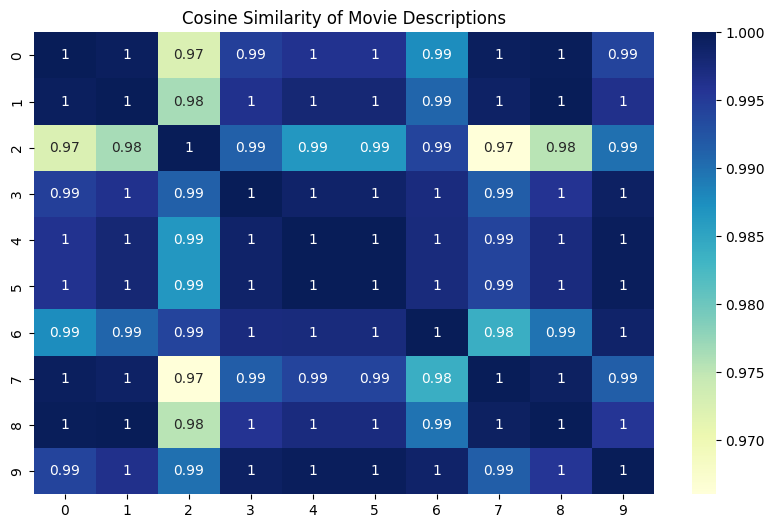

In [34]:
# 5. 유사도 행렬의 일부를 시각화 (예: 상위 5개 영화 간의 유사도)
subset_cosine_sim = cosine_sim[:10, :10]

plt.figure(figsize=(10, 6))
sns.heatmap(subset_cosine_sim, cmap='YlGnBu', annot=True)
plt.title('Cosine Similarity of Movie Descriptions')
plt.show()

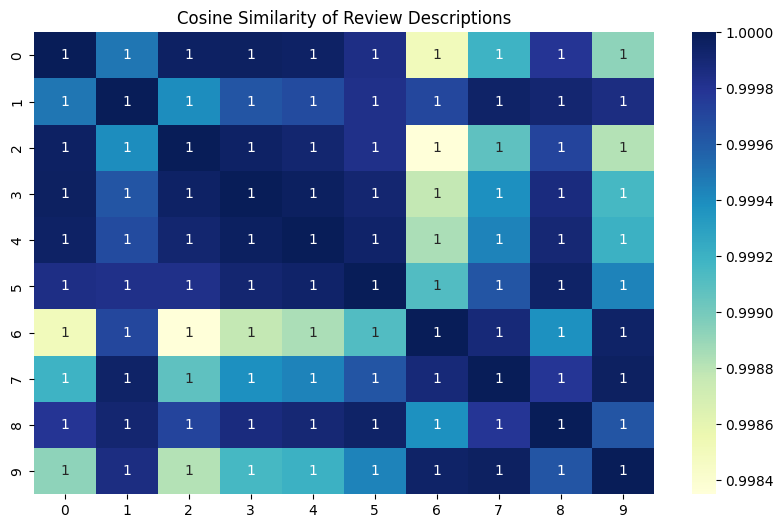

In [35]:
subset_cosine_sim_re = cosine_sim_re[:10, :10]

plt.figure(figsize=(10, 6))
sns.heatmap(subset_cosine_sim_re, cmap='YlGnBu', annot=True)
plt.title('Cosine Similarity of Review Descriptions')
plt.show()

In [36]:
def recommend_movies(movie_name, merged_df, model, top_n=5, score_weight=0.5, similarity_weight=0.5, review_weight=0.2):
    # 추천하고자 하는 영화의 인덱스 찾기
    movie_idx = merged_df[merged_df['title'] == movie_name].index[0]
    movie_vector = merged_df.loc[movie_idx]['vector'].reshape(1, -1)  # (1, 벡터 차원)
    review_vector = merged_df.loc[movie_idx]['re_vector'].reshape(1, -1)  # (1, 벡터 차원)
    movie_score = merged_df.loc[movie_idx]['imdb_score']  # 영화의 IMDB 점수

    vectors = np.vstack(merged_df['vector'].values)
    review_vectors = np.vstack(merged_df['re_vector'].values)
    imdb_scores = merged_df['imdb_score'].values

    # 각 영화와의 유사도 계산
    movie_similarities = cosine_similarity(movie_vector, vectors).flatten()  # (1, N) -> (N,)
    review_similarities = cosine_similarity(review_vector, review_vectors).flatten()

    # IMDB 점수를 기반으로 점수 계산 (영화 점수와의 차이 계산 후 가중치 적용)
    score_diff = np.abs(imdb_scores - movie_score)  # 차이가 클수록 더 낮은 점수
    score_scores = 1 / (1 + score_diff)  # 차이가 적을수록 점수가 높음

    # 최종 종합 점수 계산 (유사도와 IMDB 점수 가중합)
    final_scores = (
        similarity_weight * movie_similarities +
        review_weight * review_similarities +
        score_weight * score_scores
    )

    # 유사도가 높은 순으로 영화 정렬
    sorted_indices = final_scores.argsort()[::-1][1:top_n+1]  # 자기 자신 제외

    # 추천된 영화 제목 리스트
    recommended_movies = merged_df.iloc[sorted_indices][['title', 'imdb_score']].values.tolist()

    # 추천 영화 출력
    return recommended_movies

In [37]:
movie_name = "Inception"
recommended_movies = recommend_movies(movie_name, merged_df, model, top_n=10, score_weight=0.5, similarity_weight=0.5, review_weight=0.8)

print(f"추천된 영화들: {recommended_movies}")

추천된 영화들: [['StoryBots Super Songs', 8.8], ['The Untamed', 8.8], ['BoJack Horseman', 8.8], ['Stories by Rabindranath Tagore', 8.8], ['Peaky Blinders', 8.8], ['Better Call Saul', 8.8], ["Monty Python's Flying Circus", 8.8], ['Narcos', 8.8], ['Black Mirror', 8.8], ['Dave Chappelle', 8.699999999999998]]


영화 제목을 입력 시 해당 영화와 다른 영화들과의 모든 코사인 유사도를 구하고, 점수 차를 계산한다.

이후 가중치 수치만큼 반영해 값이 높은 순으로 출력한다.

# 2. BERT 모델

In [54]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch

# 원본 텍스트 컬럼 저장
original_movie_description = merged_df['movie_description'].copy()
original_review_description = merged_df['review_description'].copy()
original_listed_in = merged_df['listed_in'].copy()
original_title = merged_df['title'].copy()

merged_df['original_movie_description'] = original_movie_description
merged_df['original_review_description'] = original_review_description
merged_df['original_listed_in'] = original_listed_in
merged_df['title'] = original_title

merged_df['combined'] = merged_df['movie_description'] + ' ' + merged_df['listed_in'] + ' ' + merged_df['title']
merged_df['combined'] = merged_df['combined'].apply(preprocess_text)
merged_df['review_description'] = merged_df['review_description'].apply(preprocess_text)


# BERT 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to('cuda')

# 텍스트 임베딩 벡터화
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# 텍스트 임베딩 적용
merged_df['vector'] = merged_df['combined'].apply(lambda x: get_bert_embedding(x))
merged_df['re_vector'] = merged_df['review_description'].apply(lambda x: get_bert_embedding(x))
merged_df['list_vector'] = merged_df['listed_in'].apply(lambda x: get_bert_embedding(x))

vectors = np.vstack(merged_df['vector'].values)
review_vectors = np.vstack(merged_df['re_vector'].values)
cosine_sim = cosine_similarity(vectors, vectors)
cosine_sim_re = cosine_similarity(review_vectors, review_vectors)

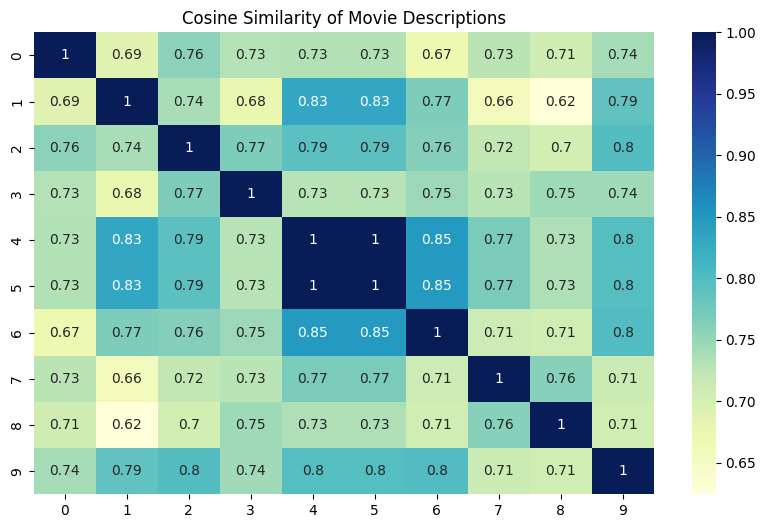

In [42]:
subset_cosine_sim = cosine_sim[:10, :10]

plt.figure(figsize=(10, 6))
sns.heatmap(subset_cosine_sim, cmap='YlGnBu', annot=True)
plt.title('Cosine Similarity of Movie Descriptions')
plt.show()

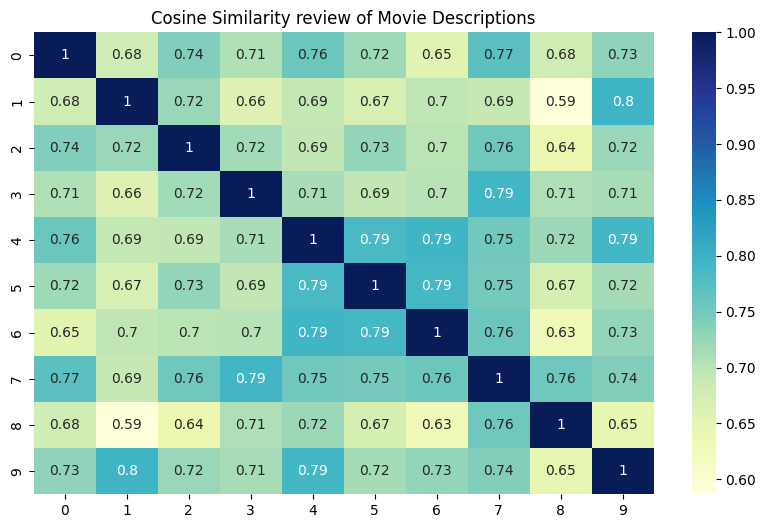

In [43]:
subset_cosine_sim_re = cosine_sim_re[:10, :10]

plt.figure(figsize=(10, 6))
sns.heatmap(subset_cosine_sim_re, cmap='YlGnBu', annot=True)
plt.title('Cosine Similarity review of Movie Descriptions')
plt.show()

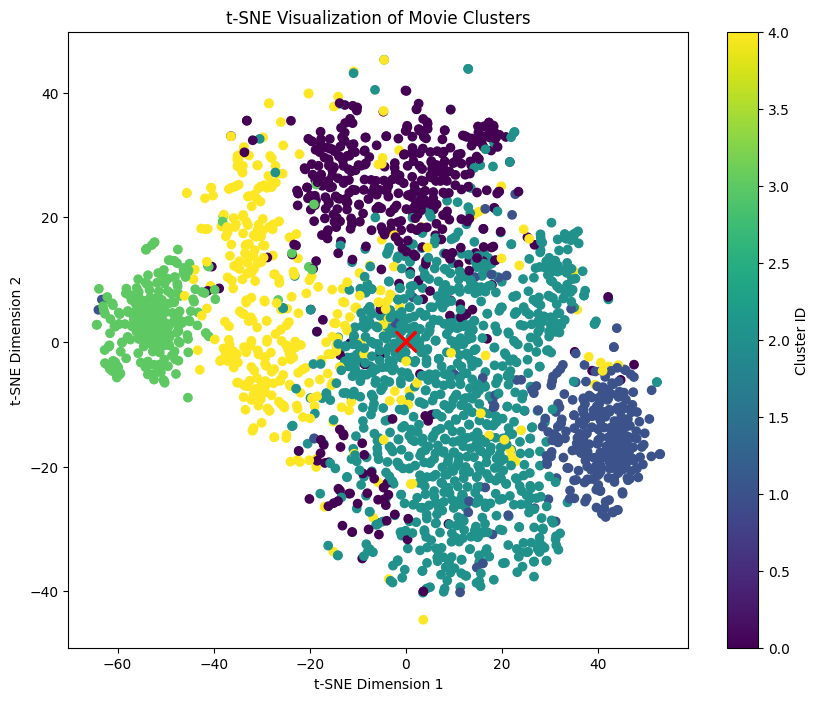

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 벡터화된 영화 설명
X = np.vstack(merged_df['vector'].values)

# KMeans 클러스터링
kmeans = KMeans(n_clusters=5, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(X)

# 클러스터 결과 시각화 (TSNE)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# 그래프 시각화
plt.figure(figsize=(10, 8))

# TSNE 결과를 scatter로 시각화
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=merged_df['cluster'], cmap='viridis')

# 각 클러스터에 대한 설명 추가
cluster_centers = kmeans.cluster_centers_

# 클러스터 중심을 그리기
for i, center in enumerate(cluster_centers):
    # 중심에 마커 표시
    plt.scatter(center[0], center[1], marker='x', s=200, c='red', label=f'Cluster {i}')

# 축 레이블 및 제목 추가
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Movie Clusters')

# 그래프 출력
plt.colorbar(scatter, label='Cluster ID')
plt.show()


# 코사인 유사도를 이용해서 추천하는 알고리즘

벡터 간의 방향의 유사성을 측정

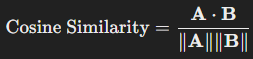

In [45]:
def recommend_movies(movie_name, merged_df, top_n=10, score_weight=0.5, similarity_weight=0.5, review_weight=0.2):
    # 추천하고자 하는 영화의 인덱스 찾기
    movie_idx = merged_df[merged_df['title'] == movie_name].index[0]
    movie_vector = merged_df.loc[movie_idx]['vector'].reshape(1, -1)  # (1, 벡터 차원)
    review_vector = merged_df.loc[movie_idx]['re_vector'].reshape(1, -1)  # (1, 벡터 차원)
    movie_score = merged_df.loc[movie_idx]['imdb_score']  # 영화의 IMDB 점수

    # 전체 영화 벡터들

    vectors = np.vstack(merged_df['vector'].values)
    review_vectors = np.vstack(merged_df['re_vector'].values)
    imdb_scores = merged_df['imdb_score'].values

    # 각 영화와의 유사도 계산(코사인)
    movie_similarities = cosine_similarity(movie_vector, vectors).flatten()  # (1, N) -> (N,)
    review_similarities = cosine_similarity(review_vector, review_vectors).flatten()

    # IMDB 점수를 기반으로 점수 계산 (영화 점수와의 차이 계산 후 가중치 적용)
    score_diff = np.abs(imdb_scores - movie_score)  # 차이가 클수록 더 낮은 점수
    score_scores = 1 / (1 + score_diff)  # 차이가 적을수록 점수가 높음

    # 최종 종합 점수 계산 (유사도와 IMDB 점수 가중합)
    final_scores = (
        similarity_weight * movie_similarities +
        review_weight * review_similarities +
        score_weight * score_scores
    )

    # 종합 점수 높은 순서로 정렬
    sorted_indices = final_scores.argsort()[::-1][1:top_n+1]  # 자기 자신 제외

    # 추천된 영화 제목 리스트
    recommended_movies = merged_df.iloc[sorted_indices][['title', 'imdb_score']].values.tolist()


    return recommended_movies

# 예시: "Inception"와 유사한 영화 추천 (IMDB 점수도 고려)
movie_name = "Inception"
recommended_movies = recommend_movies(movie_name, merged_df, top_n=10, score_weight=0.5, similarity_weight=0.5, review_weight=0.8)

print(f"추천된 영화들: {recommended_movies}")

추천된 영화들: [['The Untamed', 8.8], ['Better Call Saul', 8.8], ['Black Mirror', 8.8], ['Peaky Blinders', 8.8], ['DEATH NOTE', 9.0], ['Making a Murderer', 8.6], ['When They See Us', 8.9], ['House of Cards', 8.699999999999998], ['One-Punch Man', 8.699999999999998], ['Code Geass: Lelouch of the Rebellion', 8.699999999999998]]


# 자카드 유사도로 추천하는 알고리즘

집합 간의 공통된 비율. (겹치는 장르 비율)

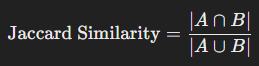

In [46]:
from sklearn.metrics import jaccard_score
import numpy as np

def jaccard_similarity(movie_vector, all_vectors):
    # 이진화된 벡터가 필요하므로, threshold를 적용해 이진형 벡터로 변환 (예: 값이 0보다 크면 1, 그렇지 않으면 0)
    movie_binary = (movie_vector > 0).astype(int)
    all_binaries = (all_vectors > 0).astype(int)

    # 각 영화와의 Jaccard 유사도 계산
    similarities = np.array([jaccard_score(movie_binary.flatten(), vec, average='binary') for vec in all_binaries])
    return similarities

def recommend_movies_jaccard(movie_name, merged_df, top_n=10, score_weight=0.5, similarity_weight=0.5, review_weight=0.2):
    # 추천하고자 하는 영화의 인덱스 찾기
    movie_idx = merged_df[merged_df['title'] == movie_name].index[0]
    movie_vector = merged_df.loc[movie_idx]['vector'].reshape(1, -1)
    review_vector = merged_df.loc[movie_idx]['re_vector'].reshape(1, -1)
    movie_score = merged_df.loc[movie_idx]['imdb_score']  # 영화의 IMDB 점수

    # 전체 영화 벡터들
    vectors = np.vstack(merged_df['vector'].values)
    review_vectors = np.vstack(merged_df['re_vector'].values)
    imdb_scores = merged_df['imdb_score'].values

    # Jaccard 유사도를 사용한 유사도 계산
    movie_similarities_j = jaccard_similarity(movie_vector, vectors)
    review_similarities_j = jaccard_similarity(review_vector, review_vectors)

    # IMDB 점수를 기반으로 점수 계산 (영화 점수와의 차이 계산 후 가중치 적용)
    score_diff = np.abs(imdb_scores - movie_score)  # 차이가 클수록 더 낮은 점수
    score_scores = 1 / (1 + score_diff)  # 차이가 적을수록 점수가 높음

    # 최종 종합 점수 계산 (유사도와 IMDB 점수 가중합)
    final_scores = (
        similarity_weight * movie_similarities_j +
        review_weight * review_similarities_j +
        score_weight * score_scores
    )

    # 상위 추천 영화 인덱스 추출
    sorted_indices = final_scores.argsort()[::-1][1:top_n+1]

    recommended_movies_j = merged_df.iloc[sorted_indices][['title', 'imdb_score']].values.tolist()

    return recommended_movies_j

movie_name = "Inception"
recommended_movies_j = recommend_movies_jaccard(movie_name, merged_df, top_n=10, score_weight=0.5, similarity_weight=0.5, review_weight=0.8)

print(f"추천된 영화들: {recommended_movies_j}")

추천된 영화들: [['The Untamed', 8.8], ['Better Call Saul', 8.8], ['Black Mirror', 8.8], ['Peaky Blinders', 8.8], ['DEATH NOTE', 9.0], ['One-Punch Man', 8.699999999999998], ['Code Geass: Lelouch of the Rebellion', 8.699999999999998], ['Sacred Games', 8.6], ['Mr. Sunshine', 8.699999999999998], ['When They See Us', 8.9]]


# 비교분석 결과

W2V 보다 BERT가 좀 더 영화 설명란의 문맥을 파악하는 데 성능이 좋다.

코사인 유사도와 자카드 유사도의 출력 결과가 다르고,

각 가중치의 크기도 다르게 해주면 다른 추천 결과가 나온다.

자카드 유사성은 중복이 중요하지 않은 경우, 코사인 유사성은 유사성을 분석하면서 중복이 중요한 경우 좋다.

두 가지 제품 설명의 경우, 단어를 반복해도 유사성이 줄어들지 않으므로 Jaccard 유사성을 사용하는 것이 더 좋다.

# IMDB 투표수 컬럼 추가하기

In [55]:
merged_df['imdb_votes'] = pd.to_numeric(merged_df['imdb_votes'], errors='coerce')
merged_df['imdb_votes'].fillna(0, inplace=True)

<ipython-input-55-aa5323cc60e1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['imdb_votes'].fillna(0, inplace=True)


# 자카드 유사도로 최종 영화 추천 알고리즘

영화이름, 설명, 리뷰내용, 투표수, 장르를 토대로 모두 가중치를 부여.

영화 장르만 해밍 유사도로 측정.

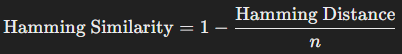

텍스트 기반 유사성(설명 및 리뷰), 장르 일치, 영화의 점수와 투표 수를 모두 결합하여 다차원적으로 추천 계산.


가중치를 사용자 정의로 조정할 수 있어, 추천 알고리즘의 결과를 특정 요소에 더 집중하도록 튜닝.


다양한 유사도 및 점수를 종합적으로 고려하여 사용자 맞춤형 추천을 제공할 수 있도록 설계.


In [62]:
from scipy.spatial.distance import hamming

def recommend_movies_jaccard(
    movie_name,
    merged_df,
    top_n,
    score_weight,
    similarity_weight,
    review_weight,
    vote_weight,
    listin_weight  # 장르 유사도 가중치 추가
):
    # 추천하고자 하는 영화의 인덱스 찾기
    movie_idx = merged_df[merged_df['title'] == movie_name].index[0]
    movie_vector = merged_df.loc[movie_idx]['vector'].reshape(1, -1)  # (1, 벡터 차원)
    review_vector = merged_df.loc[movie_idx]['re_vector'].reshape(1, -1)  # (1, 벡터 차원)
    listin_vector = merged_df.loc[movie_idx]['list_vector']  # (1, 벡터 차원)
    movie_score = merged_df.loc[movie_idx]['imdb_score']  # 추천 기준 영화의 IMDB 점수
    movieV_score = merged_df.loc[movie_idx]['imdb_votes']  # 추천 기준 영화의 IMDB 투표 수

    # 전체 영화 벡터들
    vectors = np.vstack(merged_df['vector'].values)
    review_vectors = np.vstack(merged_df['re_vector'].values)
    listin_vectors = np.vstack(merged_df['list_vector'].values)
    imdb_scores = merged_df['imdb_score'].values
    imdb_votes = merged_df['imdb_votes'].values

    # 자카드 유사도 계산
    movie_similarities = jaccard_similarity(movie_vector, vectors).flatten()
    review_similarities = jaccard_similarity(review_vector, review_vectors).flatten()

    # Hamming 거리 기반 장르 유사도 계산
    listin_similarities = np.array([
        1 - hamming(listin_vector, other_vector)
        for other_vector in listin_vectors
    ])

    # IMDB 점수를 표준화하여 점수 계산 (z-score normalization)
    mean_score = imdb_scores.mean()
    std_score = imdb_scores.std()
    score_scores = (imdb_scores - mean_score) / std_score

    # IMDB 투표율을 Min-Max 정규화하여 점수 계산
    min_votes = imdb_votes.min()
    max_votes = imdb_votes.max()
    vote_scores = (imdb_votes - min_votes) / (max_votes - min_votes)

    # 최종 점수 계산 (가중합)
    final_scores = (
        similarity_weight * movie_similarities +
        review_weight * review_similarities +
        listin_weight * listin_similarities +  # Hamming 유사도 반영
        score_weight * score_scores +
        vote_weight * vote_scores
    )

    # 점수 높은 순으로 정렬
    sorted_indices = final_scores.argsort()[::-1][1:top_n+1]  # 자기 자신 제외

    # 추천된 영화 제목 리스트
    recommended_movies_j = merged_df.iloc[sorted_indices][['title', 'imdb_score']].values.tolist()

    return recommended_movies_j

In [63]:
movie_name = "Inception"

recommended_movies = recommend_movies_jaccard(
    movie_name,
    merged_df,
    top_n=5,
    similarity_weight=0.5,
    review_weight=0.5,
    listin_weight=0.5,
    score_weight=0.5,
    vote_weight=0.5
)

recommended_df = pd.DataFrame(recommended_movies, columns=['Title', 'IMDb Score'])

# 표로 출력
print("추천된 영화들:")
print(recommended_df)

추천된 영화들:
             Title  IMDb Score
0     Breaking Bad         9.5
1       DEATH NOTE         9.0
2       Our Planet         9.3
3  Stranger Things         8.7
4  Attack on Titan         9.0


In [64]:
movie_name = "Inception"

recommended_movies = recommend_movies_jaccard(
    movie_name,
    merged_df,
    top_n=5,
    similarity_weight=0.8,
    review_weight=0.5,
    listin_weight=0.5,
    score_weight=0.5,
    vote_weight=0.5
)

recommended_df = pd.DataFrame(recommended_movies, columns=['Title', 'IMDb Score'])


print("추천된 영화들:")
print(recommended_df)

추천된 영화들:
             Title  IMDb Score
0     Breaking Bad         9.5
1       DEATH NOTE         9.0
2  Stranger Things         8.7
3       Our Planet         9.3
4  Attack on Titan         9.0


In [65]:
movie_name = "Inception"
recommended_movies_j = recommend_movies_jaccard(
    movie_name,
    merged_df,
    top_n=5,
    similarity_weight=0.8,
    review_weight=0.5,
    listin_weight=0.8,
    score_weight=0.5,
    vote_weight=0.5
)

recommended_df = pd.DataFrame(recommended_movies_j, columns=['Title', 'IMDb Score'])

print(f"추천된 영화들: ")
print(recommended_df)

추천된 영화들: 
             Title  IMDb Score
0     Breaking Bad         9.5
1       DEATH NOTE         9.0
2  Stranger Things         8.7
3       Our Planet         9.3
4  Attack on Titan         9.0


In [66]:
movie_name = "Inception"
recommended_movies_j = recommend_movies_jaccard(
    movie_name,
    merged_df,
    top_n=5,
    similarity_weight=0.8,
    review_weight=0.5,
    listin_weight=0.5,
    score_weight=0.5,
    vote_weight=0.8
)

recommended_df = pd.DataFrame(recommended_movies_j, columns=['Title', 'IMDb Score'])

print(f"추천된 영화들: ")
print(recommended_df)

추천된 영화들: 
             Title  IMDb Score
0     Breaking Bad         9.5
1  Stranger Things         8.7
2       DEATH NOTE         9.0
3  Attack on Titan         9.0
4     Black Mirror         8.8


# 결론

입력된 영화와 다른 영화 간의 코사인 유사도

해당 영화가 포함된 장르와 다른 영화 장르 간 해밍 유사도

IMDB 점수의 표준화와 투표율의 정규화 값을 모두 더해

최종 점수가 높은 순으로 추천해준다.

각 가중치를 조금씩 변경할 때마다 추천된 영화 목록들이 조금씩 바뀐다.
